In [1]:
using DataFrames, CSV
using JuMP, Gurobi
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Distributions
using Combinatorics
using ProgressMeter
using Graphs, GraphPlot
using Dates

In [2]:
function visualize_loops(df)
    G = SimpleDiGraph(length(V))
    for i in 1:nrow(df)
        add_edge!(G, df[i, :i], df[i, :j])
    end
    return G
end

visualize_loops (generic function with 1 method)

In [3]:
races = ["Sakhir", "Jeddah", "Melbourne", "Shanghai", "Baku", "Miami", "Imola", "Monaco", "Barcelona", "Montreal", "Spielberg", "Silverstone", "Budapest", "Spa", "Zandvoort", "Monza", "Singapore", "Suzuka", "Lusail", "Austin", "Mexico City", "Sao Paulo", "Las Vegas","Yas Marina"]
races_circuitref = ["bahrain", "jeddah", "albert_park", "shanghai", "baku", "miami", "imola", "monaco", "catalunya", "villeneuve", "red_bull_ring", "silverstone", "hungaroring", "spa", "zandvoort", "monza", "marina_bay", "suzuka", "losail", "americas", "rodriguez", "interlagos", "las_vegas", "yas_marina"];

In [4]:
#import Data
all_df = CSV.read("circuits.csv", DataFrame)
first(all_df,5)

Row,circuitId,circuitRef,name,location,country,lat,lng,alt,url
,Int64,String15,String,String31,String15,Float64,Float64,String7,String
1,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_Prix_Circuit
2,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.738,18,http://en.wikipedia.org/wiki/Sepang_International_Circuit
3,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.0325,50.5106,7,http://en.wikipedia.org/wiki/Bahrain_International_Circuit
4,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcelona-Catalunya
5,5,istanbul,Istanbul Park,Istanbul,Turkey,40.9517,29.405,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [5]:
select!(all_df, "circuitRef", "location", "lat", "lng")

#only keep rows for the races that we care about, i.e. 2024 schedule
df = all_df[in(races_circuitref).(all_df.circuitRef), :];

df = df[indexin(races_circuitref, df.circuitRef),:];

In [6]:
# F1 teams home locations
teams = ["Mercedes", "Ferrari", "Red Bull", "McLaren", "Aston Martin", "AlphaTauri", "Alpine", "Alfa Romeo", "Haas", "Williams"]
teams_home = ["Brackley", "Maranello", "Milton Keynes", "Woking", "Banbury", "Faenza", "Enstone", "Hinwil", "Kannapolis", "Grove"]
# get the lat and long for each team home to 3 decimal places
teams_lat = [51.683, 44.348, 52.062, 51.323, 52.056, 44.800, 51.750, 44.800, 35.233, 51.750]
teams_lng = [-1.283, 10.926, -0.759, -0.558, -1.328, 11.600, -1.200, 8.300, -80.733, -1.200]

# create a dataframe with the teams and their home locations
teams_df = DataFrame(Team = teams, Home = teams_home, lat = teams_lat, lng = teams_lng)

Row,Team,Home,lat,lng
,String,String,Float64,Float64
1,Mercedes,Brackley,51.683,-1.283
2,Ferrari,Maranello,44.348,10.926
3,Red Bull,Milton Keynes,52.062,-0.759
4,McLaren,Woking,51.323,-0.558
5,Aston Martin,Banbury,52.056,-1.328
6,AlphaTauri,Faenza,44.8,11.6
7,Alpine,Enstone,51.75,-1.2
8,Alfa Romeo,Hinwil,44.8,8.3
9,Haas,Kannapolis,35.233,-80.733


In [7]:
using Geodesy

# Gives distance between two circuits in km
function dist(c1, c2, mat)
    circuit1 = mat[c1, :]
    circuit2 = mat[c2, :]
    lat1 = circuit1[:lat]
    lng1 = circuit1[:lng]
    lat2 = circuit2[:lat]
    lng2 = circuit2[:lng]
    return euclidean_distance(LLA(lat1, lng1, 0), LLA(lat2, lng2, 0)) / 1000
end

dist (generic function with 1 method)

In [8]:
# create a distance matrix for each team home Base
dist_matrices = []
for team in eachrow(teams_df)
    df_temp = copy(df)
    team_name = team[:Team]
    team_home = team[:Home]
    team_lat = team[:lat]
    team_lng = team[:lng]
    # add a row at the beginning of df for this team
    df_temp = vcat(DataFrame(circuitRef = team_name, location = team_home, lat = team_lat, lng = team_lng), df_temp)
    # create a distance matrix for this team
    dist_mat = [dist(i, j, df_temp) for i in 1:size(df_temp, 1), j in 1:size(df_temp, 1)]
    push!(dist_matrices, dist_mat)
end

# add all the distance matrices together
dist_matrix = sum(dist_matrices)

# take the average of the distance matrix
distance_matrix = dist_matrix / size(teams_df, 1)

25×25 Matrix{Float64}:
     0.0    5233.95    4874.64  12281.8   …   8470.43   7571.14   5599.88
  5233.95      0.0     1257.42  10361.5      10191.0   10850.7     447.152
  4874.64   1257.42       0.0   10759.4       9387.08  10903.7    1613.81
 12281.8   10361.5    10759.4       0.0      10912.9   10916.7   10100.7
  8612.67   6497.96    7547.57   7518.32     12663.4    9363.14   6227.66
  4269.33   1587.46    2300.43  10840.3   …  10423.0    9945.97   1812.56
  6388.11  10429.7    10082.9   11982.6       6285.86   3454.44  10663.1
  1504.32   3956.27    3512.53  12133.8       8707.81   8732.96   4359.02
  1423.35   4255.09    3754.49  12232.2       8481.15   8601.7    4658.66
  1583.08   4611.4     4020.12  12339.2       8123.2    8507.89   5017.04
  4951.13   9204.84    8970.65  12317.0   …   7585.92   3572.49   9461.91
  1602.2    3852.59    3535.65  12067.7       8982.49   8662.08   4242.0
   986.96   5024.18    4702.93  12365.8       8637.25   7761.13   5392.55
  1886.31   3581.

In [9]:
"""
Returns a `DataFrame` with the values of the variables from the JuMP container `var`.
The column names of the `DataFrame` can be specified for the indexing columns in `dim_names`,
and the name of the data value column by a Symbol `value_col` e.g. :Value
"""
function convert_jump_container_to_df(var::JuMP.Containers.DenseAxisArray;
    dim_names::Vector{Symbol}=Vector{Symbol}(),
    value_col::Symbol=:Value)

    if isempty(var)
        return DataFrame()
    end

    if length(dim_names) == 0
        dim_names = [Symbol("dim$i") for i in 1:length(var.axes)]
    end

    if length(dim_names) != length(var.axes)
        throw(ArgumentError("Length of given name list does not fit the number of variable dimensions"))
    end

    tup_dim = (dim_names...,)

    # With a product over all axis sets of size M, form an Mx1 Array of all indices to the JuMP container `var`
    ind = reshape([collect(k[i] for i in 1:length(dim_names)) for k in Base.Iterators.product(var.axes...)],:,1)

    var_val  = value.(var)

    df = DataFrame([merge(NamedTuple{tup_dim}(ind[i]), NamedTuple{(value_col,)}(var_val[(ind[i]...,)...])) for i in 1:length(ind)])

    return df
end;

In [10]:
races = 25
home = 1
TH = 2
DH = 6
SH = races - 1 - 3 * TH - 2 * DH
subloops = SH + DH + TH

14

In [11]:
# get first #races circuitRef from initial df
circuitRefs = df[1:races-1, :circuitRef]

# create vector with string "home" and add circuitRefs to it
circuits = ["home"; circuitRefs];

In [12]:
V = 1:races
V_0 = 2:races
# remove first and last races from V_0
ind_start = findall(x->x=="bahrain", df[!, "circuitRef"])[1] + 1
ind_end = findall(x->x=="yas_marina", df[!, "circuitRef"])[1] + 1
#ind_end = 15
# remove ind_start and ind_end from V_0
V_1 = setdiff(V_0, [ind_start, ind_end])

all_S = Combinatorics.powerset(V_1, 2, length(V) - 2);

In [64]:
all_S = collect(all_S);

In [50]:
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 1)
set_optimizer_attribute(model, "Threads", 20)
#set_optimizer_attribute(model, "MIPGap", 0.005)
set_optimizer_attribute(model, "TimeLimit", 600)

println(now())
println("Defining variables")
flush(stdout)

# variables
@variable(model, x[i in V, j in V], Bin)
#@variable(model, subloops >= 1)
@variable(model, single_header[i in V], Bin)
#@variable(model, double_header[i in V_0, j in V_0], Bin)
#@variable(model, triple_header[i in V_0, j in V_0, q in V_0], Bin)

println(now())
println("Constraint: Each circuit can only be visited once")
flush(stdout)

# constraints
# each circuit can only be visited once
@constraint(model, [j in V_0], sum(x[i, j] for i in V) == 1)
@constraint(model, [i in V_0], sum(x[i, j] for j in V) == 1) 

println(now())
println("Constraint: We cannot go from circuit to itself")
flush(stdout)

# we cannot go from a circuit to itself
@constraint(model, [i in V], x[i, i] == 0)

println(now())
println("Constraint: We must start and end at home $subloops times")

# we must start and end at home and the number of loops away from home is subloops
@constraint(model, sum(x[i, 1] for i in V_0) == subloops)
@constraint(model, sum(x[1, j] for j in V_0) == subloops)

println(now())
println("Constraint: Fix a connection from home to Sakhir and put all other connections to Sakhir to zero")
flush(stdout)
@constraint(model, x[home, ind_start] == 1)
@constraint(model, [i in V_1], x[i, ind_start] == 0)

println(now())
println("Constraint: Fix a connection from Yas Marina to home and put all other connections from Yas Marina to zero")
flush(stdout)
@constraint(model, x[ind_end, home] == 1)
@constraint(model, [j in V_1], x[ind_end, j] == 0)

println(now())
println("Constraint: Make sure to not have a direct connection between Sakhir and Yas Marina")
flush(stdout)
@constraint(model, x[ind_start, ind_end] == 0)

println(now())
println("Constraint: Subloops must always connect to home")
flush(stdout)

# no subloops that do not connect to home
#p = Progress(length(all_S))
#Threads.@threads for S in all_S
for S in all_S
    @constraint(model, sum(x[i, j] for i in S, j in S) <= length(S) - 1)
#    next!(p)
end

println(now())
println("Constraint: At most $SH single headers")
flush(stdout)
@constraint(model, [i in V_0], single_header[i] <= x[home, i])
@constraint(model, [i in V_0], single_header[i] <= x[i, home])
@constraint(model, [i in V_0], single_header[i] >= x[home, i] + x[i, home] - 1)

# exactly SH single headers
@constraint(model, sum(single_header[i] for i in V_0) == SH)

#println(now())
#println("Constraint: At most $DH double headers")
#flush(stdout)

# define double_header as: 
# double_header[i, j] == 1 <=> x[home, i] == 1 and x[i, j] == 1 and x[j, home] == 1
#@constraint(model, [i in V_0, j in V_0], double_header[i, j] <= x[home, i])
#@constraint(model, [i in V_0, j in V_0], double_header[i, j] <= x[i, j])
#@constraint(model, [i in V_0, j in V_0], double_header[i, j] <= x[j, home])
#@constraint(model, [i in V_0, j in V_0], double_header[i, j] >= x[home, i] + x[i, j] + x[j, home] - 2)

# we want at most DH double-headers
#@constraint(model, sum(double_header[i, j] for i in V_0, j in V_0) <= DH)

#println(now())
#println("Constraint: At most $TH triple headers")
#flush(stdout)

# define triple_header
# triple_header[i, j] == 1 <=> x[home, i] == 1 and x[i, j] == 1 and x[j, q] == 1 and x[q, home] == 1
#@constraint(model, [i in V_0, j in V_0, q in V_0, r in V_0], triple_header[i, j, q] <= x[home, i])
#@constraint(model, [i in V_0, j in V_0, q in V_0, r in V_0], triple_header[i, j, q] <= x[i, j])
#@constraint(model, [i in V_0, j in V_0, q in V_0, r in V_0], triple_header[i, j, q] <= x[j, q])
#@constraint(model, [i in V_0, j in V_0, q in V_0, r in V_0], triple_header[i, j, q] <= x[q, home])
#@constraint(model, [i in V_0, j in V_0, q in V_0, r in V_0], triple_header[i, j, q] >= x[home, i] + x[i, j] + x[j, q] + x[q, home] - 3)

# we want at most TH triple-headers
#@constraint(model, sum(triple_header[i, j, q] for i in V_0, j in V_0, q in V_0, r in V_0) <= TH)

#println(now())
#println("Constraint: No more than three consecutive races")
#flush(stdout)

# we want at most triple-headers, so no more than 3 consecutive races
@constraint(model, [i in V_0, j in V_0, q in V_0, r in V_0], x[home, i] + x[i, j] + x[j, q] + x[q, r] <= 3)

println(now())
println("Define objective function")
flush(stdout)

#objective
@objective(model, Min, sum(sum(x[i, j] * distance_matrix[i, j] for i in V) for j in V));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-08
Set parameter Threads to value 20
Set parameter TimeLimit to value 600
2022-11-23T21:09:11.709
Defining variables


2022-11-23T21:09:11.801
Constraint: Each circuit can only be visited once


2022-11-23T21:09:11.966
Constraint: We cannot go from circuit to itself


2022-11-23T21:09:12.033
Constraint: We must start and end at home 11 times


2022-11-23T21:09:12.067
Constraint: Fix a connection from home to Sakhir and put all other connections to Sakhir to zero


2022-11-23T21:09:12.139
Constraint: Fix a connection from Yas Marina to home and put all other connections from Yas Marina to zero


2022-11-23T21:09:12.208
Constraint: Make sure to not have a direct connection between Sakhir and Yas Marina


2022-11-23T21:09:12.209
Constraint: Subloops must always connect to home


2022-11-23T21:09:25.526
Constraint: At most 3 single headers


2022-11-23T21:09:26.299
Define objective function


In [51]:
#latex_formulation(model)

In [52]:
optimize!(model)

Set parameter Threads to value 20
Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i9-12900HK, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 718920 rows, 506 columns and 50585160 nonzeros
Model fingerprint: 0x8a39433d
Variable types: 0 continuous, 506 integer (506 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 160683.25419
Presolve removed 70001 rows and 64 columns (presolve time = 10s) ...
Presolve removed 70001 rows and 64 columns (presolve time = 15s) ...
Presolve removed 70001 rows and 64 columns (presolve time = 15s) ...
Presolve removed 71086 rows and 65 columns (presolve time = 20s) ...
Presolve removed 71086 rows and 65 columns (presolve time = 29s) ...
P

In [53]:
objective_value(model)

107476.45043540186

In [54]:
x_opt = value.(x);

In [55]:
df_full = convert_jump_container_to_df(x_opt, dim_names=[:i, :j], value_col=:x)
df_1 = df_full[df_full.x .== 1, :]

3×33 DataFrame
 Row │ column  1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32   
     │ String  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ i        3     4     6     7     9    13    14    15    16    17    22     1    20    18     1    19    11     1    10     1     1     1     1    12     1     1     8     1     5     2     1    21
   2 │ j        1     1     1     1     1     1     1     1     1     1     1     2     3     4     5     6     7     8     9    10    11    12    13    14    1

In [71]:
show(DataFrame([[names(df_1)]; collect.(eachrow(df_1))], [:column; Symbol.(axes(df_1, 1))]), allcols=true, allrows=true)

3×39 DataFrame
 Row │ column  1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38   
     │ String  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ i        3     5     7     8     9    10    13    14    15    16    17    18    21    25     1     2    23    19     1    11    12     1     1     1     1     1     6     1     1     1     4     1     1    22    24     1     1    20
   2 │ j        

In [65]:
df_1 = CSV.read("result_vrp.csv", DataFrame);

In [66]:
G = visualize_loops(df_1)

{25, 38} directed simple Int64 graph

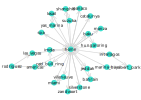

In [67]:
gplot(G, nodelabel=circuits)

In [68]:
# sum of distance matrix for each row in df_1
tot = 0
for row in eachrow(df_1)
    tot += distance_matrix[row.i, row.j]
end
tot

135925.00880903433

# Travelling Salesman

In [15]:
function find_header(df, i)
    nodes = []
    j = df[i, :j]
    if j == home
        return
    end
    push!(nodes, j)
    next = find_header(df, findfirst(df.i .== j))
    # if next is not nothing
    if next !== nothing
        # flatten the array and push
        push!(nodes, next...)
    end
    return nodes
end

# extract double and triple headers from df_manual
sequences = Vector{Vector{Int}}()
for i in 1:nrow(df_1)
    if df_1[i, :i] == home
        push!(sequences, find_header(df_1, i))
    end
end

# get rid of single length sequences
sequences = sequences[map(length, sequences) .> 1]
new = []
for header in sequences
    if length(header) == 3
        # create two arrays of length 2
        # one for the first two nodes
        # one for the last two nodes
        # push them to sequences
        push!(new, header[1:2])
        push!(new, header[2:3])
        # remove the original one
        #deleteat!(sequences, findfirst(isequal(header), sequences))
    else
        push!(new, header)
    end
end

sequences = new

find_header (generic function with 1 method)

In [17]:
model2 = Model(Gurobi.Optimizer)
set_optimizer_attribute(model2, "OutputFlag", 1)
set_optimizer_attribute(model2, "Threads", 20)
#set_optimizer_attribute(model2, "MIPGap", 0.005)
set_optimizer_attribute(model2, "TimeLimit", 600)

# variables
@variable(model2, x[i in V, j in V], Bin)
#@variable(model2, subloops >= 1)

# constraints
# each circuit can only be visited once
@constraint(model2, only_one_in[j in V_0], sum(x[i, j] for i in V) == 1)
@constraint(model2, only_one_out[i in V_0], sum(x[i, j] for j in V) == 1) 

# we cannot go from a circuit to itself
@constraint(model2, no_self_connect[i in V], x[i, i] == 0)

# we must start and end at home, only 1 subloop since we want to cover everything in one go
@constraint(model2, K_petals_in, sum(x[i, 1] for i in V_0) == 1)
@constraint(model2, K_petals_out, sum(x[1, j] for j in V_0) == 1)

# no subloops that do not connect to home
for S in all_S
    @constraint(model2, sum(x[i, j] for i in S, j in S) <= length(S) - 1)
end

# add constraints for double and triple headers
for (i, j) in sequences
    @constraint(model2, x[i, j] == 1)
end

# add constraints for begin and end race
#@constraint(model2, x[home, ind_start] == 1)
#@constraint(model2, [i in V_1], x[i, ind_start] == 0)
@constraint(model2, x[ind_end, home] == 1)
@constraint(model2, [j in V_1], x[ind_end, j] == 0)
#@constraint(model2, x[ind_start, ind_end] == 0)

#objective
@objective(model2, Min, sum(sum(x[i, j] * distance_matrix[i, j] for i in V) for j in V));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-08
Set parameter Threads to value 20
Set parameter TimeLimit to value 600


In [24]:
optimize!(model2)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i9-12900HK, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 4194388 rows, 625 columns and 530580739 nonzeros
Model fingerprint: 0x8034a09f
Variable types: 0 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]

Processed MIP start in 1.59 seconds (0.00 work units)

Presolve removed 0 rows and 0 columns (presolve time = 54s) ...
Presolve removed 0 rows and 0 columns (presolve time = 60s) ...
Presolve removed 0 rows and 0 columns (presolve time = 63s) ...
Presolve removed 1 rows and 1 columns (presolve time = 69s) ...
Presolve removed 1 rows and 1 columns (presolve time = 85s) ...
Presolve removed 64 rows and 57 columns (presolve time = 97s) ...
Presolve removed 66 ro

In [19]:
x_opt2 = value.(x);

In [20]:
df_full_2 = convert_jump_container_to_df(x_opt2, dim_names=[:i, :j], value_col=:x)
df_2 = df_full_2[df_full_2.x .== 1, :]
show(DataFrame([[names(df_2)]; collect.(eachrow(df_2))], [:column; Symbol.(axes(df_2, 1))]), allcols=true, allrows=true)

3×26 DataFrame
 Row │ column  1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25   
     │ String  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real  Real 
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ i       25    14     2    23    19    16    11    12    18    22     1    13    17     6     3    21    15     4     9     5     7    24    10     8    20
   2 │ j        1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25
   3 │ x        1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0

In [39]:
df_2 = CSV.read("result_tsp.csv", DataFrame);

In [40]:
G = visualize_loops(df_2)

{25, 25} directed simple Int64 graph

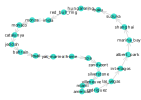

In [41]:
gplot(G, nodelabel=circuits)

In [47]:
# get total distance traveled
tot = 0
for row in eachrow(df_2)
    tot += distance_matrix[row.i, row.j]
end
tot

67773.16705402538

# RESULTS

# VRP

In [69]:
emissions_matrix = Matrix(CSV.read("emissions_matrix.csv", DataFrame));
revenue_loss_matrix = Matrix(CSV.read("revenueloss_matrix.csv", DataFrame));

LoadError: ArgumentError: "emissions_matrix.csv" is not a valid file or doesn't exist

In [33]:
results = DataFrame(alpha = Float64[], emissions = Float64[], loss = Float64[])
for alpha in 0 : 0.05 : 1
    # load tsp solution
    df_tsp = CSV.read("./tsp_results/result_tsp_$alpha.csv", DataFrame);
    # get total distance traveled
    tot_em = 0
    tot_loss = 0
    for row in eachrow(df_tsp)
        tot_em += emissions_matrix[row.i, row.j]
        tot_loss += revenue_loss_matrix[row.i, row.j]
    end
    push!(results, [alpha, tot_em, tot_loss])
end

In [34]:
results

Row,alpha,emissions,loss
,Float64,Float64,Float64
1,0.0,1.19483e7,3.31898e5
2,0.05,1.19483e7,3.31898e5
3,0.1,1.19483e7,3.31898e5
4,0.15,1.18632e7,3.42608e5
5,0.2,1.18632e7,3.42608e5
6,0.25,1.18153e7,3.55169e5
7,0.3,1.18153e7,3.55169e5
8,0.35,1.17789e7,3.71903e5
9,0.4,1.17789e7,3.71903e5


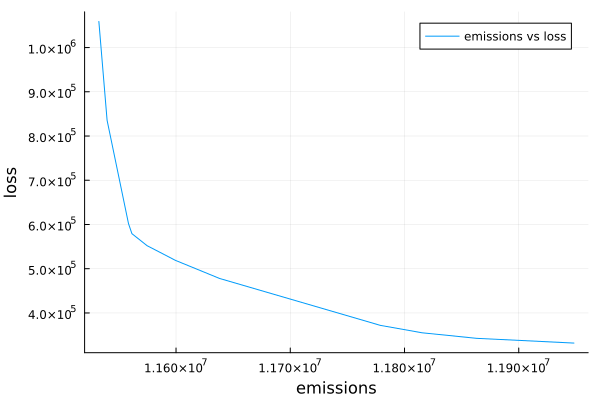

In [35]:
using Plots
# plot emissions vs loss
display("image/png", plot(results.emissions, results.loss, label="emissions vs loss", xlabel="emissions", ylabel="loss", legend=:topright))

In [17]:
average_attendance = 250000
# create 25x25 matrix filled with average attendance
attendance_loss_matrix = fill(average_attendance, 25, 25)

for i in 1:25
    for j in 1:25
        if distance_matrix[i, j] <= 250
            attendance_loss_matrix[i,j] -= 100000
        elseif distance_matrix[i, j] <= 500
            attendance_loss_matrix[i,j] -= 125000
        elseif distance_matrix[i, j] <= 1000
            attendance_loss_matrix[i,j] -= 150000
        elseif distance_matrix[i, j] <= 2000
            attendance_loss_matrix[i,j] -= 175000
        elseif distance_matrix[i, j] <= 3500
            attendance_loss_matrix[i,j] -= 200000
        elseif distance_matrix[i, j] <= 5000
            attendance_loss_matrix[i,j] -= 225000
        else 
            attendance_loss_matrix[i,j] -= 250000
        end
    end       
end

# set first column to 0
attendance_loss_matrix[:, 1] .= 0

# set first row to average_attendance
attendance_loss_matrix[1, :] .= 0

# set diagonal to 0
for i in 1:25
    attendance_loss_matrix[i, i] = 0
end

In [38]:
# write to csv
CSV.write("attendance_loss_matrix_vrp.csv", DataFrame(attendance_loss_matrix, :auto))

"attendance_loss_matrix_vrp.csv"

In [22]:
emissions_matrix_vrp = zeros(25, 25)

#Iterate through distance matrices

#If the [i,j] is in the sequences (i.e. they are consecutive), only 5 days to get there, automatically impose 5,000 km limit.

#Driving 

for i in 1:25
    for j in 1:25
        if(distance_matrix[i, j] <= 5000)
            emissions_matrix_vrp[i,j]=distance_matrix[i,j]*62 #you can drive, 62 grams/km
        else
            emissions_matrix_vrp[i,j]=distance_matrix[i,j]*500 #you have to fly, 500 grams/km
        end
    end       
end

In [39]:
# write to csv
CSV.write("emissions_matrix_vrp.csv", DataFrame(emissions_matrix_vrp, :auto))

"emissions_matrix_vrp.csv"

In [23]:
results = DataFrame(alpha = Float64[], emissions = Float64[], attendance = Float64[])
for alpha in 0 : 0.05 : 0.7
    df_vrp = CSV.read("./vrp_results/result_vrp_$alpha.csv", DataFrame);
    tot_em = 0
    tot_loss = 0
    for row in eachrow(df_vrp)
        tot_em += emissions_matrix_vrp[row.i, row.j]
        tot_loss += attendance_loss_matrix[row.i, row.j]
    end
    max_attendance = 24 * 250000
    tot_loss = max_attendance - tot_loss
    push!(results, [alpha, tot_em, tot_loss])
end
results

Row,alpha,emissions,attendance
,Float64,Float64,Float64
1,0.0,4.64725e7,5.4e6
2,0.05,4.71306e7,5.675e6
3,0.1,4.73972e7,5.7e6
4,0.15,4.73972e7,5.7e6
5,0.2,4.73972e7,5.7e6
6,0.25,4.73972e7,5.7e6
7,0.3,4.73972e7,5.7e6
8,0.35,5.07737e7,5.775e6
9,0.4,5.51681e7,5.85e6


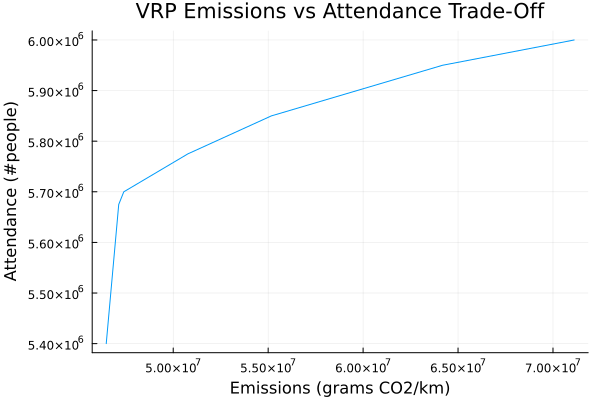

In [42]:
using Plots
# plot emissions vs loss
display("image/png", plot(results.emissions, results.attendance, title="VRP Emissions vs Attendance Trade-Off", xlabel="Emissions (grams CO2/km)", ylabel="Attendance (#people)", legend=false))

# TSP

In [70]:
df_vrp = CSV.read("./vrp_results/result_vrp_0.15.csv", DataFrame);

In [14]:
function find_header(df, i)
    nodes = []
    j = df[i, :j]
    if j == home
        return
    end
    push!(nodes, j)
    next = find_header(df, findfirst(df.i .== j))
    # if next is not nothing
    if next !== nothing
        # flatten the array and push
        push!(nodes, next...)
    end
    return nodes
end

# extract double and triple headers from df_manual
sequences = Vector{Vector{Int}}()
for i in 1:nrow(df_vrp)
    if df_vrp[i, :i] == home
        push!(sequences, find_header(df_vrp, i))
    end
end

# get rid of single length sequences
sequences = sequences[map(length, sequences) .> 1]
new = []
for header in sequences
    if length(header) == 3
        # create two arrays of length 2
        # one for the first two nodes
        # one for the last two nodes
        # push them to sequences
        push!(new, header[1:2])
        push!(new, header[2:3])
        # remove the original one
        #deleteat!(sequences, findfirst(isequal(header), sequences))
    else
        push!(new, header)
    end
end

sequences = new

10-element Vector{Any}:
 [2, 8]
 [3, 9]
 [4, 23]
 [11, 24]
 [14, 25]
 [19, 18]
 [18, 5]
 [20, 12]
 [21, 22]
 [22, 7]

In [15]:
emissions_matrix_tsp = zeros(25, 25)

#Iterate through distance matrices

#If the [i,j] is in the sequences (i.e. they are consecutive), only 5 days to get there, automatically impose 5,000 km limit.
#Otherwise, you have at least 12 days to get there, impose 8,000 km limit.

#Driving 

for i in 1:25
    for j in 1:25
        if([i, j] in sequences) #races are consecutive, only 5 days to get there
            if(distance_matrix[i, j] <= 5000)
                emissions_matrix_tsp[i,j]=distance_matrix[i,j]*62 #you can drive, 62 grams/km
            else
                emissions_matrix_tsp[i,j]=distance_matrix[i,j]*500 #you have to fly, 500 grams/km
            end
        else #races are not consecutive, at least 12 days to get there
            if(distance_matrix[i, j] <= 8000)
                emissions_matrix_tsp[i,j]=distance_matrix[i,j]*62 #you can drive, 62 grams/km
            else
                emissions_matrix_tsp[i,j]=distance_matrix[i,j]*500 #you have to fly, 500 grams/km
            end
        end
    end       
end

In [40]:
# write to csv
CSV.write("emissions_matrix_tsp_0.15.csv", DataFrame(emissions_matrix_tsp, :auto))

"emissions_matrix_tsp_0.15.csv"

In [18]:
attendance_loss_matrix_tsp = zeros(25, 25)

# devide attendance loss by 2 for all races not in sequences
for i in 1:25
    for j in 1:25
        if([i, j] in sequences)
            attendance_loss_matrix_tsp[i, j] = attendance_loss_matrix[i, j]
        else
            attendance_loss_matrix_tsp[i, j] = attendance_loss_matrix[i, j] / 2
        end
    end
end

In [41]:
# write to csv
CSV.write("attendance_loss_matrix_tsp_0.15.csv", DataFrame(attendance_loss_matrix_tsp, :auto))

"attendance_loss_matrix_tsp_0.15.csv"

In [27]:
results_tsp = DataFrame(alpha = Float64[], emissions = Float64[], attendance = Float64[], distance=Float64[])
for alpha in 0 : 0.05 : 1
    df_vrp = CSV.read("./tsp_results/result_tsp_$alpha.csv", DataFrame);
    tot_em = 0
    tot_loss = 0
    tot_dist = 0
    for row in eachrow(df_vrp)
        tot_dist += distance_matrix[row.i, row.j]
        tot_em += emissions_matrix_tsp[row.i, row.j]
        tot_loss += attendance_loss_matrix_tsp[row.i, row.j]
    end
    max_attendance = 24 * 250000
    tot_loss = max_attendance - tot_loss
    push!(results_tsp, [alpha, tot_em, tot_loss, tot_dist])
end
results_tsp

Row,alpha,emissions,attendance,distance
,Float64,Float64,Float64,Float64
1,0.0,1.07633e7,5.35e6,96506.9
2,0.05,1.08449e7,5.4375e6,97823.0
3,0.1,1.08449e7,5.4375e6,97823.0
4,0.15,1.09011e7,5.4625e6,98730.0
5,0.2,1.09011e7,5.4625e6,98730.0
6,0.25,1.09011e7,5.4625e6,98730.0
7,0.3,1.10793e7,5.4875e6,1.01603e5
8,0.35,1.16371e7,5.55e6,1.106e5
9,0.4,1.16371e7,5.55e6,1.106e5


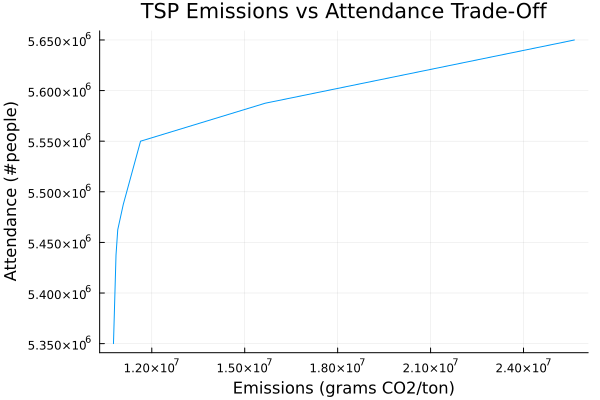

In [20]:
using Plots
display("image/png", plot(results_tsp.emissions, results_tsp.attendance, title="TSP Emissions vs Attendance Trade-Off", xlabel="Emissions (grams CO2/ton)", ylabel="Attendance (#people)", legend=false))

In [24]:
# add emissions from alpha = 0.15 to each row of results_tsp
total_result = DataFrame(alpha = Float64[], emissions = Float64[], attendance = Float64[])
for row in eachrow(results_tsp)
    push!(total_result, [row.alpha, row.emissions + results[3, :emissions], row.attendance])
end

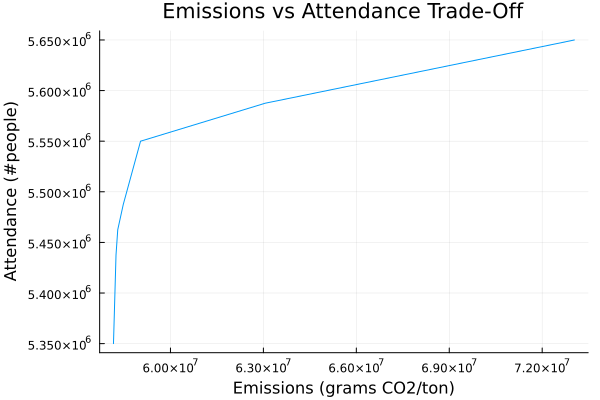

In [25]:
using Plots
display("image/png", plot(total_result.emissions, total_result.attendance, title="Emissions vs Attendance Trade-Off", xlabel="Emissions (grams CO2/ton)", ylabel="Attendance (#people)", legend=false))

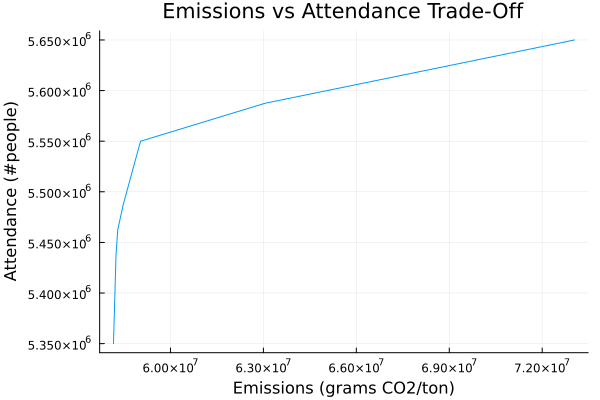

In [26]:
plot(total_result.emissions, total_result.attendance, title="Emissions vs Attendance Trade-Off", xlabel="Emissions (grams CO2/ton)", ylabel="Attendance (#people)", legend=false)

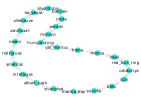

In [71]:
# plot graph for alpha = 0.5
df_vrp = CSV.read("./tsp_results/result_tsp_0.5.csv", DataFrame);
G = visualize_loops(df_vrp)
gplot(G, nodelabel=circuits)

In [14]:
#change the color for only some nodes
import Pkg
Pkg.add("Colors")
using Colors

colorant_36 = [colorant"red", colorant"blue", colorant"green", colorant"yellow", colorant"orange", colorant"purple", colorant"pink", colorant"brown", colorant"black", colorant"gray", colorant"cyan", colorant"magenta", colorant"olive", colorant"teal", colorant"coral", colorant"crimson", colorant"darkblue", colorant"darkgreen", colorant"darkred", colorant"darkviolet", colorant"gold", colorant"indigo", colorant"lime", colorant"maroon", colorant"navy", colorant"olive", colorant"orange", colorant"orchid", colorant"peru", colorant"plum", colorant"salmon", colorant"sienna", colorant"tan", colorant"turquoise", colorant"violet", colorant"yellowgreen"]
#subset of only 25 Colors
colorant_14 = colorant_36[1:14]
colorant_8 = colorant_36[1:8]

   Resolving package versions...
  No Changes to `C:\Users\guill\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\guill\.julia\environments\v1.8\Manifest.toml`


In [15]:
df_vrp = CSV.read("./vrp_results/result_vrp_0.3.csv", DataFrame);

function find_header(df, i)
    nodes = []
    j = df[i, :j]
    if j == home
        return
    end
    push!(nodes, j)
    next = find_header(df, findfirst(df.i .== j))
    # if next is not nothing
    if next !== nothing
        # flatten the array and push
        push!(nodes, next...)
    end
    return nodes
end

# extract double and triple headers from df_manual
sequences = Vector{Vector{Int}}()
for i in 1:nrow(df_vrp)
    if df_vrp[i, :i] == home
        push!(sequences, find_header(df_vrp, i))
    end
end

sequences

14-element Vector{Vector{Int64}}:
 [2, 8]
 [3, 9]
 [4, 23]
 [6]
 [10]
 [11, 24]
 [13]
 [14, 25]
 [15]
 [16]
 [17]
 [19, 18, 5]
 [20, 12]
 [21, 22, 7]

In [16]:
#declare empty array for colors of size 25
colors = Array{Colorant, 1}(undef, 25)
colors2 = Array{Colorant, 1}(undef, 25)

colors[1]=colorant"cyan"
colors2[1]=colorant"cyan"

i=1
j=1

for sequence in sequences
    for node in sequence
        if size(sequence)[1] > 1
            colors[node] = colorant_8[i]
            colors2[node] = colorant_14[j]
        else
            colors[node] = colorant"gray"
            colors2[node] = colorant_14[j]
        end
    end

    j=j+1
    
    if size(sequence)[1] > 1
        i=i+1
    end
end

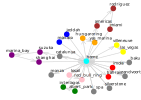

In [ ]:
G = visualize_loops(df_vrp)
gplot(G, nodefillc=colors, nodelabel=circuits, nodelabeldist=3)


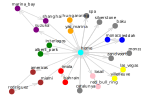

In [20]:
G = visualize_loops(df_vrp)
display(gplot(G, nodefillc=colors, nodelabel=circuits, nodelabeldist=3))

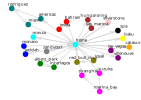

In [274]:
G = visualize_loops(df_vrp)
gplot(G, nodefillc=colors2, nodelabel=circuits, nodelabeldist=3)

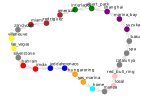

In [33]:
# plot graph for alpha = 0.5
df_vrp = CSV.read("./tsp_results/result_tsp_0.5.csv", DataFrame);
G = visualize_loops(df_vrp)
gplot(G, nodefillc=colors, nodelabel=circuits, nodelabeldist=3, nodelabelangleoffset=π/4)


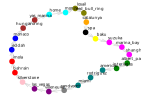

In [284]:
# plot graph for alpha = 0.5
df_vrp = CSV.read("./tsp_results/result_tsp_0.5.csv", DataFrame);
G = visualize_loops(df_vrp)
gplot(G, nodefillc=colors2, nodelabel=circuits, nodelabeldist=3, nodelabelangleoffset=π/4)